# Test on 10 images for Clustering

## Load Images

In [2]:
import pydicom
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
from lungmask import LMInferer

Get a list of Study Names

In [34]:
folder = './RBH_standard_recons'

sub_folders = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]
print(sub_folders)

base_path = '/Users/dhruvgupta/Documents/GitHub/BromptonML/RBH_standard_recons'
paths = [os.path.join(base_path, sub_folder) for sub_folder in sub_folders]
paths_dict = {sub_folder: os.path.join(base_path, sub_folder) for sub_folder in sub_folders}
print(paths[1])
print(paths_dict['VK075.7'])



['VK100.1', 'VK080.5', 'VK096.7', 'VK075.7', 'VK102.12', 'VK089.1', 'VK105.1', 'VK107.5', 'VK097.10', 'VK082.5']
/Users/dhruvgupta/Documents/GitHub/BromptonML/RBH_standard_recons/VK080.5
/Users/dhruvgupta/Documents/GitHub/BromptonML/RBH_standard_recons/VK075.7


Load DICOM series at the end folder of branch

In [ ]:
def loadImageSeries(base_path):
    # Find the last sub-folder containing files
    for root, dirs, files in os.walk(base_path, topdown=False):
    
        if files:  # Check if files exist in the current folder
            dicom_reader = sitk.ImageSeriesReader()
            dicom_files = dicom_reader.GetGDCMSeriesFileNames(root)
            dicom_reader.SetFileNames(dicom_files)
            try:
                image_out = dicom_reader.Execute()
                return image_out
            except RuntimeError as e:
                raise RuntimeError(f"Error reading DICOM series in folder {root}: {e}")
    raise RuntimeError(f"No valid DICOM series found in {base_path}")


Load images into list - NOT USED

In [ ]:
studies = []

for images in range(len(sub_folders)):  # Iterate using range
    studies.append(loadImageSeries(paths[images]))  # Append the result to the list

/Users/dhruvgupta/Documents/GitHub/BromptonML/RBH_standard_recons/VK100.1/1000051A/1000051B/1000051C
[]
['100005FE', '10000669', '1000063C', '10000656', '100005FB', '10000651', '100005C8', '1000063D', '100005C1', '100005ED', '10000658', '10000667', '1000060B', '10000693', '100005EC', '100005C6', '10000694', '1000060E', '10000660', '10000634', '1000065A', '100005F2', '1000065F', '10000633', '100005F5', '10000605', '1000069D', '100005CF', '100005E3', '1000069C', '10000602', '100005E4', '100005CA', '100005C7', '100005EB', '10000661', '1000060D', '10000695', '10000659', '100005EE', '100005C0', '10000692', '1000060C', '10000666', '100005FC', '1000063E', '100005C9', '10000650', '10000668', '100005FD', '10000657', '1000063B', '1000066F', '10000603', '1000069B', '100005E5', '10000604', '1000066A', '100005E2', '10000632', '100005F4', '10000635', '100005F3', '10000581', '10000575', '10000572', '10000586', '1000052A', '10000544', '10000588', '10000543', '1000052F', '1000058F', '1000057B', '100005

Created Nested Dictionary with data on each Image Set

In [35]:
# Initialize the nested dictionary
nested_dict = {}

# Iterate over the sub_folders
for sub_folder in sub_folders:
    folder_path = os.path.join(base_path, sub_folder)
    try:
        # Load the image series for the folder
        image_series = loadImageSeries(folder_path)
    except RuntimeError as e:
        print(f"Error loading image series for {sub_folder}: {e}")
        image_series = None  # Handle failed image loads gracefully
    
    # Populate the nested dictionary
    nested_dict[sub_folder] = {
        "path": folder_path,
        "image": image_series
    }

# Now nested_dict contains the desired structure

/Users/dhruvgupta/Documents/GitHub/BromptonML/RBH_standard_recons/VK100.1/1000051A/1000051B/1000051C
[]
['100005FE', '10000669', '1000063C', '10000656', '100005FB', '10000651', '100005C8', '1000063D', '100005C1', '100005ED', '10000658', '10000667', '1000060B', '10000693', '100005EC', '100005C6', '10000694', '1000060E', '10000660', '10000634', '1000065A', '100005F2', '1000065F', '10000633', '100005F5', '10000605', '1000069D', '100005CF', '100005E3', '1000069C', '10000602', '100005E4', '100005CA', '100005C7', '100005EB', '10000661', '1000060D', '10000695', '10000659', '100005EE', '100005C0', '10000692', '1000060C', '10000666', '100005FC', '1000063E', '100005C9', '10000650', '10000668', '100005FD', '10000657', '1000063B', '1000066F', '10000603', '1000069B', '100005E5', '10000604', '1000066A', '100005E2', '10000632', '100005F4', '10000635', '100005F3', '10000581', '10000575', '10000572', '10000586', '1000052A', '10000544', '10000588', '10000543', '1000052F', '1000058F', '1000057B', '100005

Add Pixel Spacing to nested dictionary

In [39]:
for top_level in nested_dict:
    nested_dict[top_level]['Voxel Spacing'] = nested_dict[top_level]['image'].GetSpacing()

In [41]:
print(nested_dict['VK082.5']['Voxel Spacing'])

(0.57421875, 0.57421875, 0.7)


Add Image Intensity range to Nested Dictionary

In [42]:
# Calculate intensity range if metadata is not available
stats = sitk.StatisticsImageFilter()

for top_level in nested_dict:

    stats.Execute(nested_dict[top_level]['image'])
    nested_dict[top_level]['Intensity Range'] = (stats.GetMinimum(), stats.GetMaximum())

In [43]:
print(nested_dict['VK075.7']['Intensity Range'])

(-1024.0, 2450.0)


In [47]:
# Extract all values for a specific key at the second level
key_to_extract = "Voxel Spacing"
voxel_spacings = [sub_dict[key_to_extract] for sub_dict in nested_dict.values()]


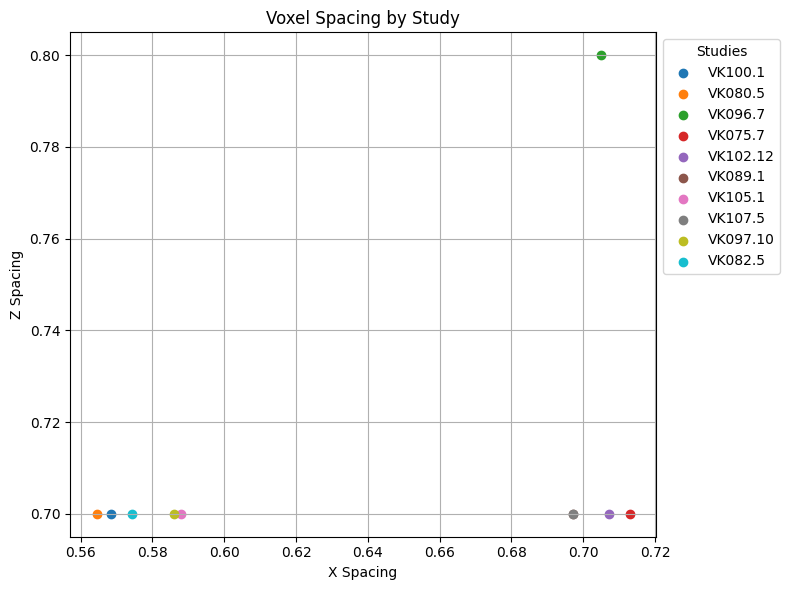

In [52]:
# Extract x and z spacings
x_spacings = [spacing[0] for spacing in voxel_spacings]
z_spacings = [spacing[2] for spacing in voxel_spacings]
labels = list(nested_dict.keys())


# Define colors for each key
colors = plt.cm.tab10(range(len(labels)))  # Use a colormap (10 colors max)

# Create the plot
plt.figure(figsize=(8, 6))
for i, key in enumerate(labels):
    plt.scatter(x_spacings[i], z_spacings[i], color=colors[i], label=key)

# Add labels and legend
plt.xlabel("X Spacing")
plt.ylabel("Z Spacing")
plt.title("Voxel Spacing by Study")
plt.legend(title="Studies", loc="upper left", bbox_to_anchor=(1, 1))  # Color-coded legend
plt.grid(True)
plt.tight_layout()  # Adjust layout for readability
plt.show()